In [ ]:
import torch
import timm
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define your class names (adjust based on your dataset)
class_names = ["apple_scab", "apple_Black_rot", "apple_Cedar_apple_rust", "apple_healthy"]

# Load the model architecture
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)

# Define the path to your model file in Google Drive
model_path = "/content/drive/My Drive/apple_vit_model.pth"  # Adjust the path if needed

# Load the model weights
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Move model to device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set model to evaluation mode
model.eval()

print(f"Model loaded successfully from {model_path}")


Mounted at /content/drive


<ipython-input-1-135b3ce8183c>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Model loaded successfully from /content/drive/My Drive/apple_vit_model.pth


Saving scab_large.jpg to scab_large (6).jpg
Uploaded file: scab_large (6).jpg
File scab_large (6).jpg found.


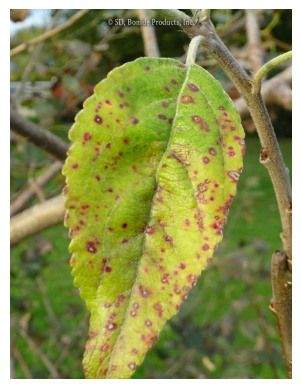

Predicted class: apple_scab 
confidence: 91.27


Description:
Apple scab is caused by the fungus Venturia inaequalis, which results in dark, scabby lesions on the leaves, fruit, and sometimes young shoots.

Cures:
- Use fungicides such as captan, mancozeb, or sulfur-based sprays during the growing season.
- Prune and dispose of infected leaves and fruits to reduce the spread of the fungus.
- Ensure proper air circulation by thinning the trees and avoid overhead watering.


In [ ]:
# Import necessary libraries
import torch
import torchvision.transforms as transforms
from google.colab import files
from PIL import Image
import os
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt  # Importing matplotlib for image display

# Function to display an image
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()  # Show the image

# Function to make predictions on images and plot them with prediction confidence
def pred_and_plot_image(model, image_path, class_names, device):
    # Load image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))  # Assuming your model uses 224x224 image size

    # Preprocess image (adjust based on your model's preprocessing)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img)  # Get raw model outputs (logits)
        probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        confidence, predicted_class = torch.max(probabilities, 1)  # Get the class with highest probability

    # Get class name and confidence
    predicted_class_name = class_names[predicted_class.item()]
    predicted_confidence = confidence.item()

    # Return result
    return predicted_class_name, predicted_confidence

# Assuming you used ImageFolder to load your dataset for training
# This will extract the class names automatically from your dataset folder structure
dataset = ImageFolder(root="/content/drive/MyDrive/Apple", transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))
class_names = dataset.classes  # Extract class names from the dataset

# Upload the image from local machine
uploaded = files.upload()

# Get the uploaded file name
image_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {image_filename}")

# Ensure the uploaded image file exists
if os.path.isfile(image_filename):
    print(f"File {image_filename} found.")
else:
    raise FileNotFoundError(f"{image_filename} not found. Please upload the file.")

# Display the uploaded image
display_image(image_filename)  # Call the display function to show the image

# Assuming 'vit' is your model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)  # Move model to GPU if available

# Call the prediction function
predicted_class_name, predicted_confidence = pred_and_plot_image(model, image_path=image_filename, class_names=class_names, device=device)

# Define your disease cure database
disease_cure_database = {
    "apple_scab": {
        "description": "Apple scab is caused by the fungus Venturia inaequalis, which results in dark, scabby lesions on the leaves, fruit, and sometimes young shoots.",
        "cures": [
            "Use fungicides such as captan, mancozeb, or sulfur-based sprays during the growing season.",
            "Prune and dispose of infected leaves and fruits to reduce the spread of the fungus.",
            "Ensure proper air circulation by thinning the trees and avoid overhead watering."
        ]
    },
    "apple_Black_rot": {
        "description": "Apple Black Rot is caused by the fungus Botryosphaeria obtusa. It causes cankers on branches, black spots on fruit, and leaf lesions.",
        "cures": [
            "Prune infected branches during the dormant season.",
            "Remove and destroy infected fruit and leaves.",
            "Use fungicides like captan or myclobutanil, especially after fruit set."
        ]
    },
    "apple_Cedar_apple_rust": {
        "description": "Cedar apple rust is caused by the fungus Gymnosporangium juniperi-virginianae. It leads to orange spots on the leaves and fruit, reducing the yield.",
        "cures": [
            "Apply fungicides such as myclobutanil or mancozeb in early spring.",
            "Remove any nearby cedar or juniper trees to reduce the source of the fungus.",
            "Prune affected parts of the tree to limit spread."
        ]
    },
    "apple_healthy": {
        "description": "No disease present; ensure ongoing healthy practices to maintain tree health.",
        "cures": [
            "Regular watering, ensuring proper drainage.",
            "Apply balanced fertilizers to ensure the tree gets all essential nutrients.",
            "Regularly inspect for pests or early signs of disease."
        ]
    }
}

# Display the predicted class and confidence
print(f"Predicted class: {predicted_class_name} \nconfidence: {predicted_confidence * 100:.2f}\n\n")

# Display the disease description and cure if found in the database
if predicted_class_name in disease_cure_database:
    disease_info = disease_cure_database[predicted_class_name]

    print(f"Description:\n{disease_info['description']}\n")
    print("Cures:")
    for cure in disease_info['cures']:
        print(f"- {cure}")

else:
    print(f"No information available for the predicted class: {predicted_class_name}")
